## 6.400 Sequence processing with convnets

Convnets are good for CV tasks

They extract and modularise salient 2D information from local patches

1D data - timeseries - might have similar local regularities

And then 1D convnets would provide a cheap alternative to RNNs

----

## 6.410 1D convolutions

Operate just as 2D convnets - the same convolution is applied throughout the timeseries

A convolution of size 5 would recognise words or word fragments of length 5 or less at any point in the input sequence



Patterns learned at a certain position in a sentence can be recognised elsewhere - a kind of translation invariance (temporal invariance)

----

## 6.420 1D pooling for sequence data

Works just like 2D pooling - max or average pooling

Used for subsampling - reducing the length of 1D inputs

----

## 6.430 Implementing a 1D convnet

The 1D convnet is implemented in `tensorflow.keras` as the `Conv1D` layer

It takes 3D tensor input `(samples, time, features)` and returns 3D tensors of the same shape

The convolution window is a 1D window on the temporal axis (axis 1)

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence


max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are typically stacks of `Conv1D` and `MaxPooling1D` layers

The stack ends in either a global pooling layer or a `Flatten` layer, 

The 3D outputs are turned into 2D tensors, suitable for input to a dense classifier or regressor 

Let's build a 2 layer 1D convnet for the IMDB sentiment classification task 

Use a larger convolution window than the typical 2D  local receptive field: windows of size 7 or 9 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

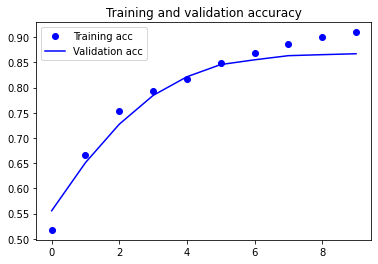

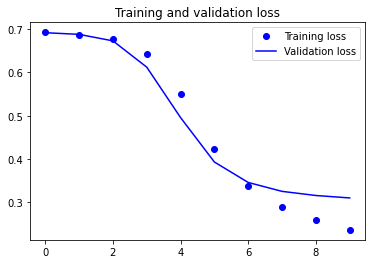

In [4]:
plt.show()

Validation accuracy is lower than the equivalent LSTM model 

But runtime is faster

We should now retrain on all the training data for the optimal epoch (longer runs are probabLy needed) and evaluate on the test set 

So 1D convnet can offer fast, cheap alternatives to a recurrent network on a word-level sentiment classification task

----

## 6.440 Combining CNNs and RNNs to process long sequences

1D convnets are not sensitive to order beyond the patch size

RNNs, of course, are - in principle - sensitive to order at any timescale

A large stack of 1D convnet and pooling layers might be able to recognize long-term patterns 

Lets try a stacked 1D convnet on the temperature forecast problem 

In [8]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

data_dir = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 35ms/step - loss: 0.4110 - val_loss: 0.4827
Epoch 2/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3560 - val_loss: 0.4384
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3319 - val_loss: 0.4362
Epoch 4/20
500/500 [==============================] - 18s 35ms/step - loss: 0.3158 - val_loss: 0.4995
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3034 - val_loss: 0.4380
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2937 - val_loss: 0.4661
Epoch 7/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2862 - val_loss: 0.4473
Epoch 8/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2787 - val_loss: 0.4949
Epoch 9/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2738 - val_loss: 0.4606
Epoch 10/20
500/500 [==============================] - 19s 39ms/step - loss: 0.268

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

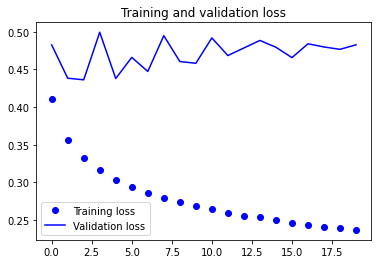

In [11]:
plt.show()

Abject failure - cannot beat even the common sense baseline

The convnet looks for patterns anywhere in the timeseries but has no knowledge of the temporal position of that pattern (at the beginning, the end, etc.)

But we know recent weather datapoints are more salient than older datapoints

That's why this convnet fails to produce a meaningful result

The local limitation is not an issue for sentiment analysis because salient patterns of keywords ('great movie', 'a real stinker') are informative irrespective of their position in the review

Preprocess the sequence with a 1D convnet before applying an RNN layer

A compromise that blends the speed and local pattern spotting of a 1D convnet with the power and order-sensitivy  of an RNN

This compromise is especially beneficial when dealing with very long sequences

Sequences with thousands of steps cannot be realistically processed with RNNs 

A convnet will compress a long input sequence into a much shorter sequence of higher-level features

This sequence of extracted features is fed into an RNN layer

Let's try 1D convnet preprocessing on the temperature forecasting dataset 

The network can manipulate much longer sequences
    - input data from further back (increasing the generator `lookback`)
    - or look at high-resolution timeseries (decreasing `step` ) 

We will use a `step` of half the size, resulting in a double length timeseries

i.e. the weather data is being sampled at a rate of one point per 30 minutes

In [12]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

The model, two `Conv1D` layers followed by a `GRU` layer:

In [13]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 55s 110ms/step - loss: 0.3344 - val_loss: 0.2901
Epoch 2/20
50

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

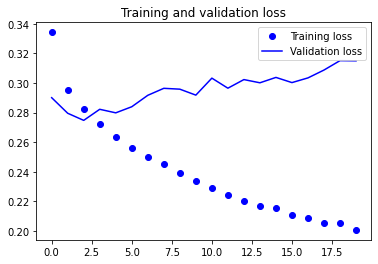

In [14]:
plt.show()

The performance is not quite as good as the regularized GRU but it's significantly faster

It is looking at twice the data - not so helpful here - but may be important for other timeseries

----

## 6.450 Wrapping up

- 1D convnets spot local (in time) patterns in 1D ordered data 

- They are faster than RNNs but not as general

- Typically 1D convnets consist of stacks of `Conv1D` and `MaxPooling1D` layers and end in a global pooling operation or a flattening operation

- RNNs are impractical for very long sequences: use a 1D convnet as a preprocessing step before an RNN to shorten the sequence and extract useful representation

----